In [1]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "tilebox",
#     "xarray",
#     "matplotlib",
#     "ipywidgets",
#     "numpy",
#     "shapely",
#     "rasterio",
#     "scipy",
# ]
# ///

<img src="https://uploads-ssl.webflow.com/64b58e06654493327b4a59ee/6508a6973bb25aebe94d4fde_tilebox-color.svg" alt="Tilebox" width="200"/>

# Challenge 2: Earth Observation Change Detection & Risk Assessment

This notebook provides a starting point for the challenge. It covers:
- Querying and filtering EO datasets from Tilebox over a specific spatio-temporal extent
- Filtering by cloud cover
- Downloading the data
- Loading the data into memory and visualizing it
- Computing a simple change metric
- Next steps and resources for a successful challenge submission


**Tilebox docs available at**: [docs.tilebox.com](https://docs.tilebox.com/)

Join us on Discord: <a href="https://tilebox.com/discord">
<img src="https://img.shields.io/badge/Discord-%235865F2.svg?style=flat-square&logo=discord&logoColor=white" alt="Join us on Discord"/>
</a>

## Dependencies

Install [uv](https://docs.astral.sh/uv/) and then launch this notebook with:

```bash
uvx juv run Earth_Observation_Challenge.ipynb
```

(The `uvx` command is included when installing `uv`).

In [2]:
from tilebox.datasets import Client
from shapely.geometry import shape
import xarray as xr

# Fetching before/after imagery for the 2021 California Dixie Fire

[2021 California Dixie Fire](https://en.wikipedia.org/wiki/Dixie_Fire)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/2021_Dixie_Fire_map_1.png/960px-2021_Dixie_Fire_map_1.png" width="600" height="600">

## Querying relevant imagery

First we define our target area and our time range to query

In [5]:
# rough bounding box of the dixie fire area, generated by drawing a polygon on https://geojson.io/ 
dixie_fire_bbox = shape({"type": "Polygon", "coordinates": [
           [[-121.244,40.349],
            [-121.244,40.045],
            [-120.894,40.045],
            [-120.894,40.349],
            [-121.244,40.349]]]
})

# The fire lasted from 2021-07-13 to 2021-10-25
time_range_before_fire = ("2021-06-01", "2021-07-01")

# However for the after image here we look at it a year later
# in summer again, so that the visual comparison due to the sun
# angle is easier here
time_range_after_fire = ("2022-06-01", "2022-07-01")

In [6]:
def query(dataset, collections, temporal_extent, spatial_extent):
    """
    Query a spatio-temporal Tilebox dataset for a given temporal and spatial extent

    Args:
        dataset: The Tilebox Dataset to query
        collections: List of collection names to query in
        temporal_extent: (start, end) time to query
        spatial_extent: Polygon specifying the area to query

    Returns:
        xr.Dataset with the found results
    """
    all_results = []
    for collection in collections:
        results = dataset.collection(collection).query(
            temporal_extent=temporal_extent,
            # more information: https://docs.tilebox.com/datasets/query/filter-by-location#intersects
            spatial_extent={"geometry": spatial_extent, "mode": "intersects"}
        )
        if results:
            all_results.append(results)

    if not all_results:  # no matches found, return an empty dataset
        return xr.Dataset()

    return xr.concat(all_results, dim="time")

In [7]:
# query L2 data products from all three sentinel 2 satellites
sentinel2_l2_collections = ["S2A_S2MSI2A", "S2B_S2MSI2A", "S2C_S2MSI2A"]

# Create your key here: https://console.tilebox.com/account/api-keys
client = Client(token="<YOUR_TILEBOX_API_KEY>")
sentinel2 = client.dataset("open_data.copernicus.sentinel2_msi")

before = query(sentinel2, sentinel2_l2_collections, time_range_before_fire, dixie_fire_bbox)
after = query(sentinel2, sentinel2_l2_collections, time_range_after_fire, dixie_fire_bbox)

if before:
    print(f"  ✓ Found {before.sizes['time']} matching granules before the fire.")
else:
    print(f"  ✗ No matching granules found before the fire.")

if after:
    print(f"  ✓ Found {after.sizes['time']} matching granules after the fire.")
else:
    print(f"  ✗ No matching granules found after the fire.")

  ✓ Found 6 matching granules before the fire.
  ✓ Found 12 matching granules after the fire.


## Filter for cloud coverage

In [8]:
max_cloud_cover = 1  # maximum 1 % cloud cover

before = before.isel(time=before.cloud_cover <= max_cloud_cover)
after = after.isel(time=after.cloud_cover <= max_cloud_cover)

print(f"Matching granules with cloud coverage <10%")
print(f"  - {before.sizes['time']} granules before the fire")
print(f"  - {after.sizes['time']} granules after the fire.")

Matching granules with cloud coverage <10%
  - 3 granules before the fire
  - 2 granules after the fire.


## Accessing Product Data

Tilebox doesn't host the actual image data, just the metadata catalog for efficient indexing and querying. To access an download Copernicus data, you can use the [Tilebox Copernicus storage client](https://docs.tilebox.com/storage/clients#copernicus-data-space).

#### Copernicus S3 Credentials

To access the data, you'll need to create a free account at https://dataspace.copernicus.eu/

And then, once logged in generate `S3` Credentials on this page:

https://eodata-s3keysmanager.dataspace.copernicus.eu/panel/s3-credentials

In [9]:
from tilebox.storage import CopernicusStorageClient

In [8]:
copernicus_storage_client = CopernicusStorageClient(
    access_key="<YOUR_S3_ACCESS_KEY>",  # see credentials description above
    secret_access_key="<YOUR_S3_SECRET_ACCESS_KEY>"
)

### Preview Quicklook

Before we download the full product (which is quite large), let's quickly preview an image to make sure we got the area right

In [11]:
before_product = before.isel(time=0)  # select any one of the granules
after_product = after.isel(time=-1)  # using regular python list index logic (-1 means last one)

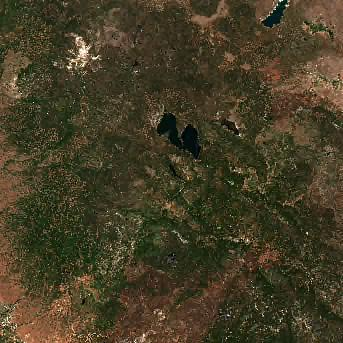

In [12]:
copernicus_storage_client.quicklook(before_product)

### Downloading and querying product files

That looks good, let's download the actual payload data

Sentinel-2 data is available in **multiple resolutions**, and every band is located in its own file.
For a quick visual analysis, we typically want to load three bands in the Red, Green and Blue spectral range, so that we can compute an RGB composite.

The necessary information about the Sentinel-2 MSI Instrument can be found here:
https://sentiwiki.copernicus.eu/web/s2-mission#S2Mission-SpatialResolutionS2-Mission-Spatial-Resolutiontrue

![](https://sentiwiki.copernicus.eu/__attachments/1687033/image-20230605-122808.png?inst-v=620842ee-e3f1-4a41-be8e-09f8a7d4808d)

### Downloading the Before-fire product

We'll choose the 20m resolution version of the data, for a quick visualization

In [13]:
product_files = copernicus_storage_client.list_objects(before_product)
resolution_20m_files_before = [file for file in product_files if "R20m" in file]
red_band_20m_before = [file for file in resolution_20m_files_before if "B04" in file][0]
green_band_20m_before = [file for file in resolution_20m_files_before if "B03" in file][0]
blue_band_20m_before = [file for file in resolution_20m_files_before if "B02" in file][0]

In [14]:
before_product_path = copernicus_storage_client.download_objects(before_product, [red_band_20m_before, green_band_20m_before, blue_band_20m_before])

### Downloading the After-fire product

Let's do the same for the `after` product

In [15]:
product_files = copernicus_storage_client.list_objects(after_product)
resolution_20m_files_after = [file for file in product_files if "R20m" in file]
red_band_20m_after = [file for file in resolution_20m_files_after if "B04" in file][0]
green_band_20m_after = [file for file in resolution_20m_files_after if "B03" in file][0]
blue_band_20m_after = [file for file in resolution_20m_files_after if "B02" in file][0]

In [16]:
after_product_path = copernicus_storage_client.download_objects(after_product, [red_band_20m_after, green_band_20m_after, blue_band_20m_after])

### Reading products as numpy arrays

We'll use [rasterio](https://rasterio.readthedocs.io/en/stable/) to read the Sentinel-2 product files into memory

In [17]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def read_band(product_path, band_name) -> np.ndarray:
    with rasterio.open(product_path / band_name) as arr:
        return arr.read(1) / 10000  # s2 reflectance values are stored as uint16, scaled by factor 10000

In [19]:
before_rgb_composite = np.stack([
    read_band(before_product_path, red_band_20m_before),
    read_band(before_product_path, green_band_20m_before),
    read_band(before_product_path, blue_band_20m_before),
], axis=-1)

In [20]:
after_rgb_composite = np.stack([
    read_band(after_product_path, red_band_20m_after),
    read_band(after_product_path, green_band_20m_after),
    read_band(after_product_path, blue_band_20m_after),
], axis=-1)

## Visualize the change

In [21]:
# compute difference between the two images
change = np.linalg.norm(before_rgb_composite - after_rgb_composite, axis=2)

In [22]:
brighten_factor = 2.6  # the reflectance values are quite dark, let's brighten it a bit for visualization

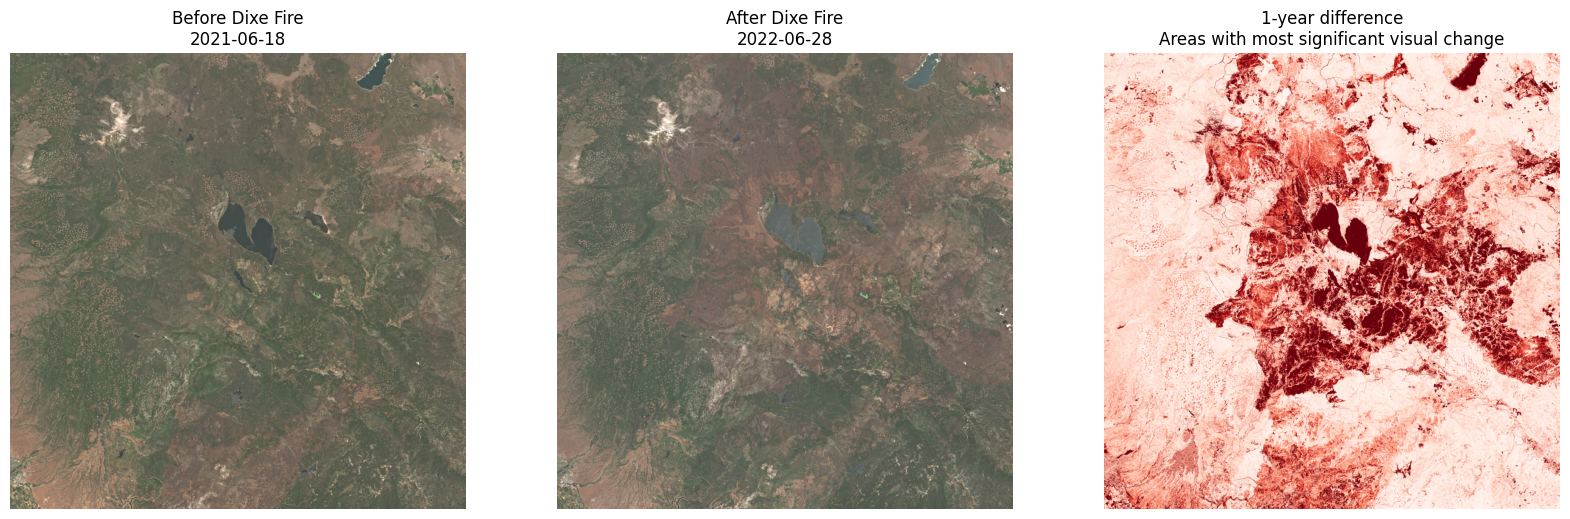

In [24]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(20, 10)

axes[0].imshow(np.clip(before_rgb_composite * brighten_factor, 0, 1))
axes[0].axis("off")
axes[0].set_title(f"Before Dixe Fire\n{before_product.time.dt.strftime('%Y-%m-%d').item()}")

axes[1].imshow(np.clip(after_rgb_composite * brighten_factor, 0, 1))
axes[1].axis("off")
axes[1].set_title(f"After Dixe Fire\n{after_product.time.dt.strftime('%Y-%m-%d').item()}")

axes[2].imshow(change, cmap="Reds", vmin=np.percentile(change, 10), vmax=np.percentile(change, 90))
axes[2].axis("off")
axes[2].set_title("1-year difference\nAreas with most significant visual change");

## Next Steps

This Notebook is intended to get you started quickly with the Change Detection & Risk Assessment challenge. Listed below are some suggested next step, to hopefully help get your idea off the ground in no time!

---

### 🎯 Pick the right datasets

Sentinel-2 is just one of the missions with publicly available data that you can use. Check the datasets overview in the Challenge `README.md` for a list of other datasets that might be useful. Depending on the exact application, here are some relevant ones for various use cases.

- **Sentinel-1 SAR**: Essential for Flood Extent Mapping and Building Damage Assessment due to its all-weather, day/night capability and sensitivity to structural changes.

- **Sentinel-2 MSI**: The primary dataset for Wildfire Burn Scars (using NBR/dNBR) and base layers for Urban Heat Islands (using NDVI) and Building Damage Assessment. Its 10 m resolution is a good balance of detail and coverage.

- **Landsat-8/9 TIRS**: Crucial for thermal analysis in Urban Heat Islands and Volcanic Activity, providing the necessary long-wave infrared bands.

- **Satellogic EarthView / Wyvern Dragonette / Umbra SAR**: These provide higher resolution and/or more specialized spectral data (Hyperspectral/High-Res SAR) to enhance the precision of Building Damage Assessment and fine-scale change detection. Wyvern's hyperspectral bands in the VNIR are excellent for detailed vegetation state analysis.

---

### 📐 Data Reprojection & Regridding

To successfully build a multi-temporal change detection or risk assessment system using the diverse datasets provided (e.g., combining Sentinel-1 SAR with Landsat-8 TIRS and Sentinel-2 MSI), you will very likely need to regrid all data onto a common spatial grid.

**Why is Regridding Necessary?**

Each satellite mission uses a different sensor, orbit, and processing system, resulting in distinct properties for the data products:

- Coordinate Reference System (CRS): Data is often delivered in different projections (e.g., UTM, Web Mercator, WGS 84). You need a consistent CRS (e.g., UTM Zone for your specific AOI) to align features accurately.

- Pixel Size (Resolution): Data has different native resolutions (e.g., Sentinel-2 at 10 m, Landsat-8 Thermal at 100 m, Umbra SAR at 1 m). Direct pixel-by-pixel comparison or stacking is impossible without resampling the data to a single, chosen resolution.

- Grid Alignment: Even if two datasets have the same nominal resolution, their pixel corners might not perfectly overlap. Regridding ensures that all pixels are perfectly aligned on a shared grid system.


More information on this topic, and a **guide using `odc.geo`**: [Reprojecting datacube and raster data ](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Reprojecting_data/)

---

## 🔬 Core Analysis Methods & Spectral Indices

Choosing the correct derived product or index is critical for turning raw satellite measurements into meaningful change metrics. Some well known indices that might prove useful are listed below.

#### 🔥 Normalized Burn Ratio (NBR) & Delta NBR (dNBR)

* **Scenario:** **Wildfire Burn Scars**
* **Sensor Data:** Sentinel-2 MSI (Optimal: NIR and SWIR2 bands)
* **Formula / Principle:**
    * **NBR:**
        $NBR = \frac{(NIR - SWIR2)}{(NIR + SWIR2)}$
    * **dNBR:**
        $dNBR = NBR_{pre-fire} - NBR_{post-fire}$
    * **Principle:** NBR measures vegetation health and water content. Healthy vegetation has high **NIR** reflectance and low **SWIR2** reflectance. Fire damage drastically **decreases** the NIR (due to loss of chlorophyll) and **increases** the SWIR2 (due to drying and charring). The difference, **dNBR**, quantifies the severity of the burn.

####  💧 Normalized Difference Vegetation Index (NDVI)

* **Scenario:** **Urban Heat Islands** (as a complementary metric)
* **Sensor Data:** Sentinel-2 MSI or Satellogic EarthView (RGB, NIR bands)
* **Formula / Principle:**
    * **NDVI:**
        $NDVI = \frac{(NIR - Red)}{(NIR + Red)}$
    * **Principle:** Measures vegetation density and health. Healthy green vegetation strongly **reflects NIR** and strongly **absorbs Red** light, resulting in high positive values. In the Urban Heat Island scenario, low-NDVI areas combined with high LST indicate areas lacking cooling vegetation, thereby increasing heat risk.

####  🌊 Normalized Difference Water Index (NDWI)

* **Scenario:** **Flood Extent Mapping** (as an optical method)
* **Sensor Data:** Sentinel-2 MSI or Landsat (Green and NIR bands)
* **Formula / Principle:**
    * **NDWI:**
        $NDWI = \frac{(Green - NIR)}{(Green + NIR)}$
    * **Principle:** **Water** strongly absorbs NIR light and reflects green light, resulting in high positive values. This index is excellent for differentiating open water bodies from soil and vegetation, making it suitable for mapping flood boundaries in clear-sky conditions.

####  📡 SAR Backscatter Analysis / SAR Coherence Change

* **Scenario:** **Flood Extent Mapping** and **Building Damage Assessment**
* **Sensor Data:** Sentinel-1 SAR (C-band, VV/VH polarizations)
* **Formula / Principle:**
    * **Flood Mapping:** Analyze pre-event versus post-event backscatter ($\sigma^{\circ}$). **Smooth water** acts as a specular reflector, bouncing the signal away from the satellite, causing a significant **drop** in the backscatter signal (low $\text{VV}$ and $\text{VH}$).
    * **Damage Assessment (Coherence):** Measures the phase similarity between two SAR acquisitions. Physical changes to buildings (e.g., destruction) between the two acquisition dates cause the signal to change drastically, resulting in a large **drop in coherence** over the damaged area. 

####  💨 Ash Index (e.g., NDSI derivative)

* **Scenario:** **Volcanic Activity** (Ash Plumes)
* **Sensor Data:** Sentinel-2 MSI
* **Formula / Principle:**
    * **Formula:** Often uses a ratio similar to NDSI (Normalized Difference Snow Index) but optimized for ash. A common approach involves **Visible** and **SWIR** bands.
    * **Principle:** Volcanic ash particles have distinct spectral signatures compared to clouds. Ash typically absorbs visible light and reflects highly in certain SWIR bands. By leveraging these differences, specialized indices can be used to detect and track ash plumes, which pose a major risk to air travel.

---

## 🧠 Alternative Analysis: AI-Based Change Detection with Foundation Models

While traditional spectral indices (NDVI, NBR) offer robust and interpretable solutions, a powerful alternative is leveraging **Geospatial Foundation Models (GeoFMs)**. These pre-trained models fundamentally change how multi-sensor and multi-temporal change detection is approached.

### What is a Foundation Model in EO?

A **Foundation Model (FM)** is a massive model trained on an enormous, diverse dataset using **self-supervised learning**. Instead of being trained for one specific task (like classifying crops), it learns generalized patterns, feature relationships, and spatial/temporal context across the entire planet.

* GeoFMs eliminate the need to label thousands of images yourself. They provide a high-quality "starting point" by generating **embeddings** (compact numerical feature vectors) for every pixel or image chip. These embeddings already encode deep knowledge about what the terrain looks like.
* **Change Detection Method:** Instead of calculating $\Delta NBR$, you calculate the **distance or difference** between the embeddings of the *pre-event* image and the *post-event* image. A large difference in the embedding space signifies a significant change on the ground.

### Example: [Clay: An Open Geospatial Foundation Model](https://clay-foundation.github.io/model/index.html)

The **Clay Foundation Model** is a prominent, open-source GeoFM designed for Earth observation applications. It has been trained on massive amounts of data, including:

* Sentinel-1 (SAR)
* Sentinel-2 (Optical)
* Landsat-8/9 (Optical/Thermal)

#### How Clay could be used for Change Detection:

1.  **Generate Embeddings:** Use the pre-trained Clay model to input your Sentinel-1, Sentinel-2, and Landsat images and output a **semantic embedding** for your AOI at both $t_1$ (pre-event) and $t_2$ (post-event).
2.  **Calculate Change Vector:** Compute the difference between the two embedding vectors. This is your **Change Vector**.
3.  **Threshold/Cluster:** Apply clustering algorithms (e.g., K-Means) or simple distance thresholds to the Change Vector to classify the pixels into your required severity classes (e.g., "no change," "moderate change," "severe change").

This approach is highly effective for combining **multimodal data** (like Sentinel-1 SAR and Sentinel-2 optical) without complex manual alignment or index calculation. Using Clay allows you to leverage its pre-trained global intelligence to potentially achieve superior results with less custom code. 